## semi - supervised learning을 위한 문장 분류 모델

현재 데이터가 labeling이 되어있지 않은 상태고 labeling을 수기로 하지 않고 모델을 이용해서 할 것이다. 
따라서 문장을 classification하는 model을 설계할 것이다. 

### 1. data 불러오기
to_label.ipynb 파일을 이용해서 label을 위한 데이터를 만들어뒀다.
이를 불러와서 classification하는 모델을 만들어보자!

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

import matplotlib.pyplot as plt
import csv

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SentenceDataset(Dataset) :
    def __init__(self, sentences, labels = None) :
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self) :
        return len(self.sentences)
    
    def __getitem__(self, index) :
        sentence = self.sentences[index]
        inputs = self.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        if self.labels is not None : 
            label = self.labels[index]
            return input_ids, attention_mask, torch.tensor(label)
        else : 
            return input_ids, attention_mask

In [3]:
label_data_path = "./dataset/my_data_0702.csv"
csv_data = pd.read_csv(label_data_path)

In [4]:
from sklearn.model_selection import train_test_split

In [137]:
train_x, test_x, train_y, test_y = train_test_split(csv_data['sentence'],csv_data['label'],shuffle=True,stratify=csv_data["label"],test_size=0.2)

In [138]:
print(type(train_x))
print(type(csv_data['sentence']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [5]:
csv_data.columns
len(csv_data)
csv_data[csv_data['label']==8]

,id,sentence,label
0,0,현재 홍익대학교의 총장님은 누구인가요?,8
1,1,홍대 총장님은 누구세요?,8
2,2,학교 총장은 지금 누구야?,8
3,3,홍익대학교의 총장이 누구인지 알아요?,8
4,4,홍대 총장님 성함이 뭐야?,8
...,...,...,...
395,395,홍익대학교 현황은 어떻게 돼?,8
396,396,홍대 현황을 설명해 봐.,8
397,397,학교의 현재 상태를 설명해 줘.,8
398,398,홍익대학교의 현황을 알고 싶어.,8


In [6]:
print("Columns in CSV:", csv_data.columns)
csv_data['sentence']

Columns in CSV: Index(['id', 'sentence', 'label'], dtype='object')


0                   현재 홍익대학교의 총장님은 누구인가요?
1                           홍대 총장님은 누구세요?
2                          학교 총장은 지금 누구야?
3                    홍익대학교의 총장이 누구인지 알아요?
4                          홍대 총장님 성함이 뭐야?
                      ...                
4482      전자공학과의 졸업 관련 공지사항은 어디서 볼 수 있나요?
4483            건축학과의 성적 발표 관련 공지사항이 있나요?
4484     화학공학과의 학사 일정 변경 공지사항은 어떻게 확인하나요?
4485     산업디자인학과의 학사 경고 관련 공지사항은 어디서 찾나요?
4486    생명과학과의 학적 변경 관련 공지사항은 무엇이 있는지 알려줘
Name: sentence, Length: 4487, dtype: object

In [8]:
# 패딩 적용
def collate_fn(batch):
    input_ids = [item[0] for item in batch]
    attention_masks = [item[1] for item in batch]

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    if len(batch[0]) == 3 :
        labels = [item[2] for item in batch]
        labels = torch.stack(labels)
        return input_ids, attention_masks, labels
    else : 
        return input_ids, attention_masks

In [9]:
dataset = SentenceDataset(csv_data['sentence'], csv_data['label'])
# dataset = SentenceDataset(train_x, train_y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn,drop_last=True)
# dataloader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn, drop_last=True)

In [164]:
print(train_x[1])
# print(dataset.sentences[1])

KeyError: 1

In [10]:
print(dataset[1])


(tensor([  101,  1469, 30011, 30025, 29993, 30007,  1465, 30011, 30025, 30000,
        30006, 30025, 29992, 30019, 30023, 29999, 30017, 30021,  1456, 30014,
        29991, 30014, 29997, 30009, 29999, 30013,  1029,   102]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]), tensor(8))


### 2. bert를 이용한 sentenceClassifier

In [11]:
class SentenceClassifier(nn.Module) :
    def __init__(self, num_labels) :
        super(SentenceClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_labels)

    def forward(self, input_ids, attention_mask) :
        outputs = self.bert(input_ids=input_ids, attention_mask = attention_mask)
        return outputs.logits

In [16]:
model = SentenceClassifier(11)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)
# optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3. train model

In [17]:
def train_model(model, dataloader, criterion, optimizer, epochs = 5) :
    model.train()
    epoch_losses = []
    for epoch in range(epochs) :
        epoch_loss = 0
        for input_ids, attention_mask, labels in dataloader :
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_losses.append(epoch_loss / len(dataloader))
        print(f"Epoch {epoch+1}, Loss : {loss.item()}")
    return epoch_losses

In [18]:
def plot_losses(losses) : 
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

Epoch 1, Loss : 0.2901730239391327
Epoch 2, Loss : 0.36455708742141724
Epoch 3, Loss : 0.019300304353237152
Epoch 4, Loss : 0.025463072583079338
Epoch 5, Loss : 0.027708876878023148
Epoch 6, Loss : 0.00440436415374279
Epoch 7, Loss : 0.010734712705016136
Epoch 8, Loss : 0.004711222369223833
Epoch 9, Loss : 0.0024771385360509157
Epoch 10, Loss : 0.4004836082458496


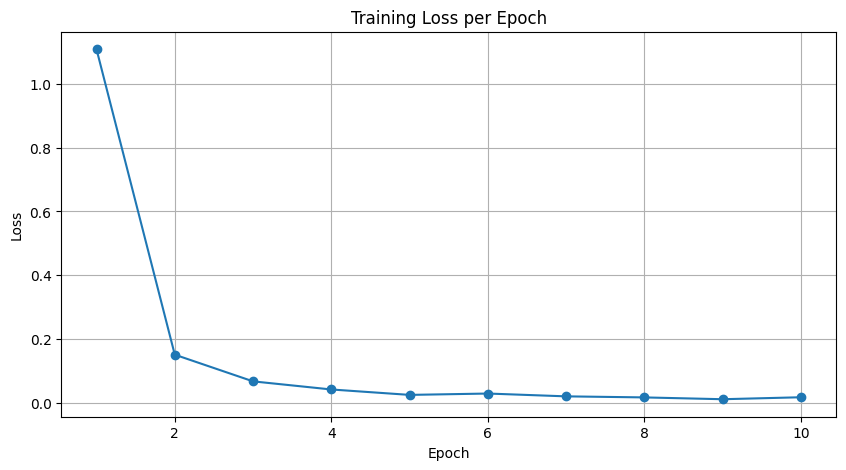

In [19]:
epoch_losses = train_model(model, dataloader, criterion, optimizer, 10) 
plot_losses(epoch_losses)

### evaluate model

In [20]:
def evaluate_model(model, dataloader) :
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad() :
        for input_ids, attention_mask, labels in dataloader :
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy : {correct / total * 100:.2f}%")

In [21]:
evaluate_model(model, dataloader)

Accuracy : 99.75%


### 4. test model
label이 붙지 않은 데이터를 넣어보며 테스트를 해보자. 

In [22]:
# 테스트 데이터 (라벨이 없는 경우)
test_sentences = [
    "홍익대학교는 이사장이 이면영입니까?.",
    "학식이 맛있는지 아닌지 어떻게 알죠?",
    "홍익대학교는 명문 대학교입니다.",
    "홍익대학교 pc실이 어디였죠?",
    "홍익대학교 스케쥴이 궁금합니다.",
    "컴공 과사무실 번호 좀 알려주세요",
    "회화과 공지사항 좀 보여줘",
    "오늘 비가 올까?",
    "열람실 자리가 있어?",
    "졸업 요건이 뭐가 부족한지 알고싶어"
]


In [23]:
test_dataset = SentenceDataset(test_sentences)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [24]:
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for input_ids, attention_mask in dataloader:
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

In [25]:
test_predictions = predict(model, test_dataloader)
for sentence, prediction in zip(test_sentences, test_predictions) : 
    print(f"Sentence: {sentence}\t Prediction: {prediction}\n")

Sentence: 홍익대학교는 이사장이 이면영입니까?.	 Prediction: 8

Sentence: 학식이 맛있는지 아닌지 어떻게 알죠?	 Prediction: 1

Sentence: 홍익대학교는 명문 대학교입니다.	 Prediction: 8

Sentence: 홍익대학교 pc실이 어디였죠?	 Prediction: 4

Sentence: 홍익대학교 스케쥴이 궁금합니다.	 Prediction: 7

Sentence: 컴공 과사무실 번호 좀 알려주세요	 Prediction: 3

Sentence: 회화과 공지사항 좀 보여줘	 Prediction: 5

Sentence: 오늘 비가 올까?	 Prediction: 1

Sentence: 열람실 자리가 있어?	 Prediction: 10

Sentence: 졸업 요건이 뭐가 부족한지 알고싶어	 Prediction: 9



### 5. model save

모델을 저장하자

In [ ]:
save_path = "label_class_model"
torch.save(model.state_dict(), save_path)